In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the corpus
with open('corpus.txt', 'r') as f:
    corpus_words = [line.strip().lower() for line in f if line.strip()]

# Load the test set
with open('test.txt', 'r') as f:
    test_words = [line.strip().lower() for line in f if line.strip()]

print(f"Corpus size: {len(corpus_words)} words")
print(f"Test set size: {len(test_words)} words")

Corpus size: 50000 words
Test set size: 2000 words


In [5]:
print(f"\nFirst 10 corpus words: {corpus_words[:10]}")
print(f"First 10 test words: {test_words[:10]}")


First 10 corpus words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
First 10 test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


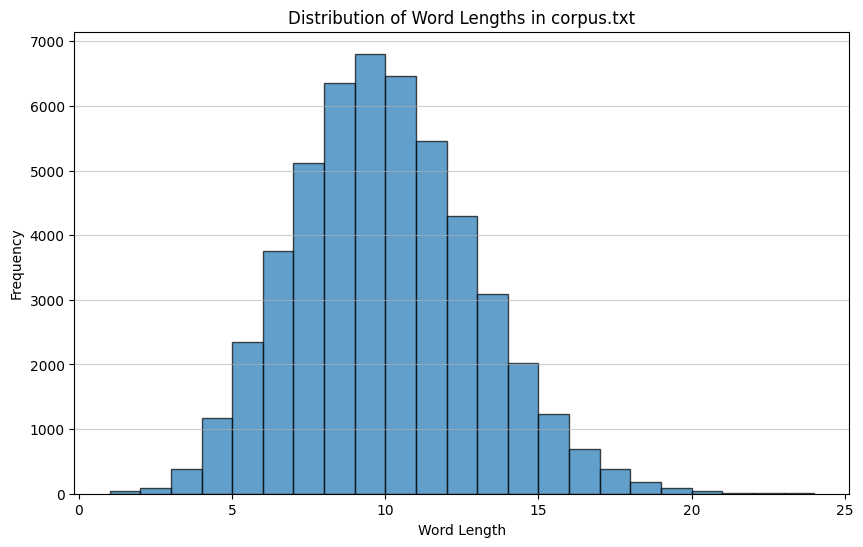

In [13]:
plt.figure(figsize=(10, 6))
corpus_lengths = [len(word) for word in corpus_words]
plt.hist(corpus_lengths, bins=range(1, max(corpus_lengths)+1), edgecolor='black', alpha=0.7) # Plot histogram of word lengths
plt.title('Distribution of Word Lengths in corpus.txt')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.6)
plt.show()

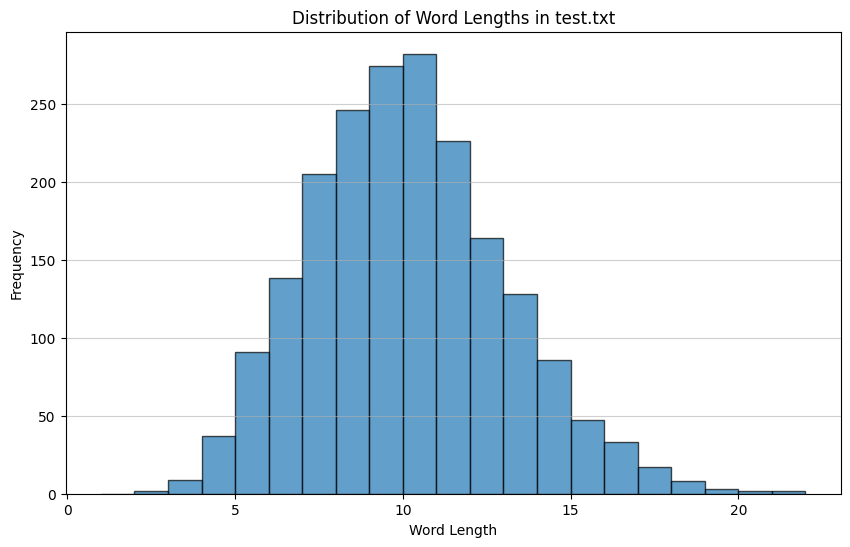

In [14]:
plt.figure(figsize=(10, 6))
test_lengths = [len(word) for word in test_words]
plt.hist(test_lengths, bins=range(1, max(test_lengths)+1), edgecolor='black', alpha=0.7) # Plot histogram of word lengths
plt.title('Distribution of Word Lengths in test.txt')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [18]:
# statistics
print("corpus.txt")
print(f"Min word length: {min(corpus_lengths)}")
print(f"Max word length: {max(corpus_lengths)}")
print(f"Mean word length: {np.mean(corpus_lengths):.2f}")
print(f"Median word length: {np.median(corpus_lengths):.2f}")
print(f"Std word length: {np.std(corpus_lengths):.2f}")

corpus.txt
Min word length: 1
Max word length: 24
Mean word length: 9.50
Median word length: 9.00
Std word length: 2.96


In [19]:
print("test.txt")
print(f"Min word length: {min(test_lengths)}")
print(f"Max word length: {max(test_lengths)}")
print(f"Mean word length: {np.mean(test_lengths):.2f}")
print(f"Median word length: {np.median(test_lengths):.2f}")
print(f"Std word length: {np.std(test_lengths):.2f}")

test.txt
Min word length: 2
Max word length: 22
Mean word length: 9.64
Median word length: 9.00
Std word length: 2.92



Top 15 Most Frequent Letters:
Letter  Count  Percentage
     e  49224   10.365719
     a  42110    8.867634
     i  42068    8.858790
     o  35829    7.544965
     r  33619    7.079577
     n  33314    7.015349
     t  32191    6.778865
     s  29044    6.116162
     l  27406    5.771227
     c  21718    4.573433
     u  18397    3.874088
     p  16426    3.459030
     m  14670    3.089247
     d  14324    3.016385
     h  13643    2.872979


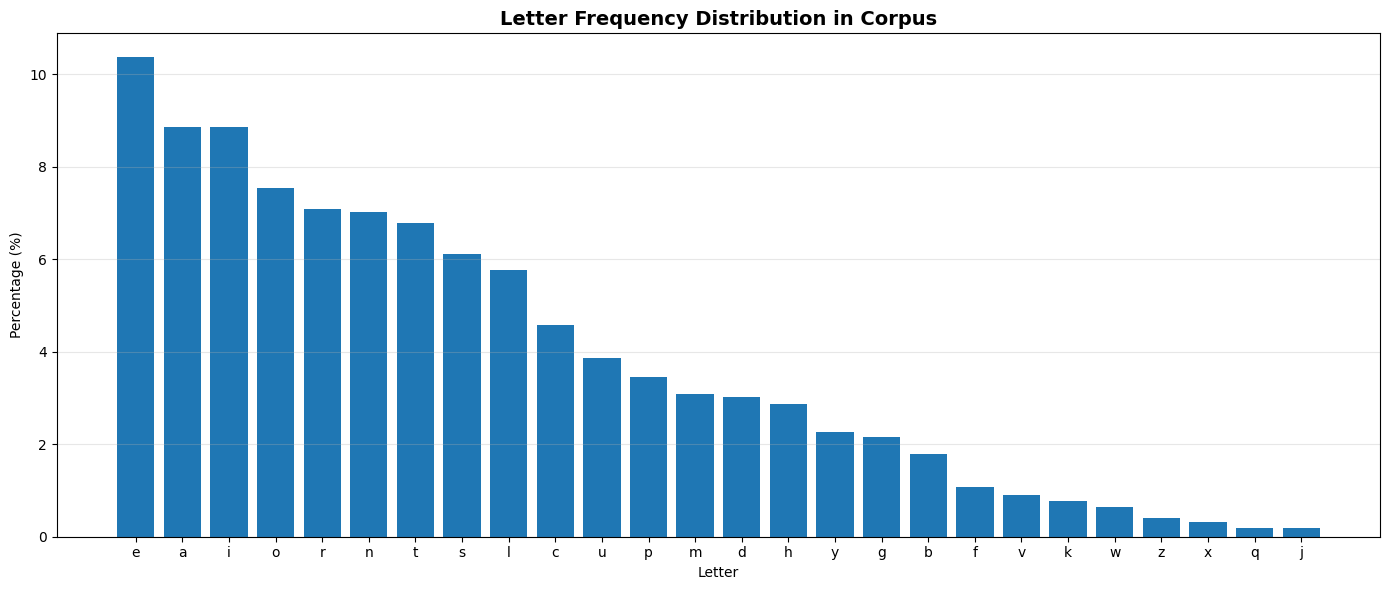

In [20]:
# letter frequency analysis

# Count letter frequencies
all_letters = ''.join(corpus_words)
letter_freq = Counter(all_letters)
total_letters = sum(letter_freq.values())

# Create DataFrame for better visualization
freq_df = pd.DataFrame([
    {'Letter': letter, 'Count': count, 'Percentage': (count/total_letters)*100}
    for letter, count in letter_freq.most_common()
])

print("\nTop 15 Most Frequent Letters:")
print(freq_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(14, 6))
plt.bar(freq_df['Letter'][:26], freq_df['Percentage'][:26])
plt.title('Letter Frequency Distribution in Corpus', fontsize=14, fontweight='bold')
plt.xlabel('Letter')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [21]:
# data cleaning

# Check for invalid characters
def validate_words(words, dataset_name):
    valid_chars = set('abcdefghijklmnopqrstuvwxyz')
    invalid_words = []

    for word in words:
        if not set(word).issubset(valid_chars):
            invalid_words.append(word)

    print(f"\n{dataset_name} Validation:")
    print(f"Total words: {len(words)}")
    print(f"Invalid words: {len(invalid_words)}")

    if invalid_words:
        print(f"Sample invalid words: {invalid_words[:5]}")

    return [word for word in words if set(word).issubset(valid_chars)]

In [22]:
# Clean datasets
corpus_words_clean = validate_words(corpus_words, "Corpus")
test_words_clean = validate_words(test_words, "Test Set")

# Check for duplicates
print(f"\nCorpus duplicates: {len(corpus_words_clean) - len(set(corpus_words_clean))}")
print(f"Test duplicates: {len(test_words_clean) - len(set(test_words_clean))}")

# Remove duplicates
corpus_words = list(set(corpus_words_clean))
test_words = list(set(test_words_clean))

print(f"\nFinal corpus size: {len(corpus_words)}")
print(f"Final test size: {len(test_words)}")


Corpus Validation:
Total words: 50000
Invalid words: 21
Sample invalid words: ['au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir']

Test Set Validation:
Total words: 2000
Invalid words: 0

Corpus duplicates: 582
Test duplicates: 0

Final corpus size: 49397
Final test size: 2000


# HMM Implementation
## Architecture:
- Hidden states: Letter positions in a word
- Emissions: The actual letters at each position
- Approach: Train separate HMMs for each word length

## Reasoning:
- We are using this approach as words of different lengths have different patterns
- Position-specific information helps predict likely letters
- Helps us capture linguistic patterns like common word endings (such as -ing, -tion)

In [124]:
class MultiLevelHMM:
    def __init__(self):
        self.word_dict = defaultdict(list)
        self.bigram_freq = defaultdict(Counter)
        self.trigram_freq = defaultdict(Counter)
        self.state_transitions = {'V': Counter(), 'C': Counter(), 'START': Counter()}
        self.position_freq = {'start': Counter(), 'end': Counter(), 'middle': Counter()}
        self.letter_freq = Counter()
        self.vowels = set('aeiou')
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')

    def train(self, words):
        print("Training Fixed Multi-Level HMM...")

        for word in tqdm(words, desc="Training"):
            self.word_dict[len(word)].append(word)

            for letter in word:
                self.letter_freq[letter] += 1

            for i in range(len(word) - 1):
                self.bigram_freq[word[i]][word[i+1]] += 1

            for i in range(len(word) - 2):
                context = word[i:i+2]
                self.trigram_freq[context][word[i+2]] += 1

            prev_state = 'START'
            for letter in word:
                curr_state = 'V' if letter in self.vowels else 'C'
                self.state_transitions[prev_state][letter] += 1
                prev_state = curr_state

            if len(word) > 0:
                self.position_freq['start'][word[0]] += 1
                self.position_freq['end'][word[-1]] += 1
                for letter in word[1:-1]:
                    self.position_freq['middle'][letter] += 1

        print(f"Trained on {len(words)} words")

    def get_letter_probabilities(self, masked_word, guessed_letters, damping=0.08):
        remaining = self.alphabet - guessed_letters

        if not remaining:
            return {}

        letter_scores = defaultdict(float)
        for letter in remaining:
            letter_scores[letter] = self.letter_freq.get(letter, 1) * 0.01

        # === EXPLICIT PATTERNS (Highest Priority) ===
        if 'q' in masked_word and 'u' in remaining:
            for pos, char in enumerate(masked_word):
                if char == 'q' and pos < len(masked_word) - 1:
                    if masked_word[pos + 1] == '_':
                        letter_scores['u'] += 10000

        if 'q' in masked_word:
            for pos, char in enumerate(masked_word):
                if char == 'q' and pos > 0 and masked_word[pos - 1] == '_':
                    for vowel in 'aei':
                        if vowel in remaining:
                            letter_scores[vowel] += 800

        # Double letter patterns
        for pos in range(len(masked_word) - 1):
            if masked_word[pos] != '_' and masked_word[pos + 1] == '_':
                letter = masked_word[pos]
                if letter in remaining and letter in 'slpfecm':
                    letter_scores[letter] += 300

        # Common endings
        if masked_word.endswith('_ng'):
            if 'i' in remaining:
                letter_scores['i'] += 500
        if masked_word.endswith('_ed'):
            for l in 'tdsr':
                if l in remaining:
                    letter_scores[l] += 300
        if masked_word.endswith('_ly'):
            for l in 'aeil':
                if l in remaining:
                    letter_scores[l] += 300
        if masked_word.endswith('_ion'):
            for l in 'tacs':
                if l in remaining:
                    letter_scores[l] += 300

        # === GAME PROGRESS ANALYSIS ===
        blank_count = masked_word.count('_')
        game_progress = 1 - (blank_count / len(masked_word))

        # === LEVEL 1: Pattern Matching ===
        matching_words = self._get_matching_words(masked_word, guessed_letters)

        if len(matching_words) > 0:
            # Weight increases in late game
            base_weight = 100
            if game_progress >= 0.7:
                base_weight = 800  # HUGE boost in late game
            elif game_progress >= 0.5:
                base_weight = 300

            confidence = min(len(matching_words) / 20, 1.0)
            weight = base_weight * confidence

            for word in matching_words:
                for pos, letter in enumerate(word):
                    if masked_word[pos] == '_' and letter in remaining:
                        letter_scores[letter] += weight

        # === LEVEL 2: Trigrams ===
        for pos in range(len(masked_word)):
            if masked_word[pos] != '_':
                continue

            if pos >= 2 and masked_word[pos-2] != '_' and masked_word[pos-1] != '_':
                context = masked_word[pos-2:pos]
                if context in self.trigram_freq:
                    for letter, count in self.trigram_freq[context].items():
                        if letter in remaining:
                            letter_scores[letter] += count * 10.0

        # === LEVEL 3: Bigrams ===
        for pos in range(len(masked_word)):
            if masked_word[pos] != '_':
                continue

            if pos > 0 and masked_word[pos-1] != '_':
                prev_letter = masked_word[pos-1]
                for letter, count in self.bigram_freq[prev_letter].items():
                    if letter in remaining:
                        letter_scores[letter] += count * 3.0

            if pos < len(masked_word) - 1 and masked_word[pos+1] != '_':
                next_letter = masked_word[pos+1]
                for prev, counts in self.bigram_freq.items():
                    if next_letter in counts and prev in remaining:
                        letter_scores[prev] += counts[next_letter] * 2.0

        # === LEVEL 4: V/C States ===
        blanks = [i for i, c in enumerate(masked_word) if c == '_']
        for blank_pos in blanks:
            if blank_pos > 0 and masked_word[blank_pos-1] != '_':
                prev_letter = masked_word[blank_pos-1]
                prev_state = 'V' if prev_letter in self.vowels else 'C'
                for letter, count in self.state_transitions[prev_state].items():
                    if letter in remaining:
                        letter_scores[letter] += count * 0.05
            elif blank_pos == 0:
                for letter, count in self.state_transitions['START'].items():
                    if letter in remaining:
                        letter_scores[letter] += count * 0.05

        # === LEVEL 5: Positions ===
        for blank_pos in blanks:
            if blank_pos == 0:
                for letter in remaining:
                    letter_scores[letter] += self.position_freq['start'].get(letter, 1) * 1.0
            elif blank_pos == len(masked_word) - 1:
                for letter in remaining:
                    letter_scores[letter] += self.position_freq['end'].get(letter, 1) * 1.0
            else:
                for letter in remaining:
                    letter_scores[letter] += self.position_freq['middle'].get(letter, 1) * 0.2

        # Convert to probabilities
        total = sum(letter_scores.values())
        if total == 0:
            probs = {l: self.letter_freq.get(l, 1) for l in remaining}
            total = sum(probs.values())
            probs = {k: v/total for k, v in probs.items()}
        else:
            probs = {letter: score / total for letter, score in letter_scores.items()}

        # Apply damping
        uniform_prob = 1.0 / len(remaining)
        final_probs = {}
        for letter in remaining:
            final_probs[letter] = (1 - damping) * probs.get(letter, 0) + damping * uniform_prob

        total = sum(final_probs.values())
        if total > 0:
            final_probs = {k: v/total for k, v in final_probs.items()}

        return final_probs

    def _get_matching_words(self, masked_word, guessed_letters):
        length = len(masked_word)
        if length not in self.word_dict:
            return []

        # FIXED: Only care about letters we KNOW are wrong
        ruled_out = set()
        for letter in guessed_letters:
            if letter not in masked_word:
                ruled_out.add(letter)

        matching = []
        for word in self.word_dict[length]:
            if self._matches_fixed(word, masked_word, ruled_out):
                matching.append(word)

        return matching

    def _matches_fixed(self, word, masked_word, ruled_out):
        """FIXED: Simpler, correct matching logic"""
        if len(word) != len(masked_word):
            return False

        for w_char, m_char in zip(word, masked_word):
            if m_char != '_':
                # Revealed: must match
                if w_char != m_char:
                    return False
            else:
                # Blank: can't have ruled-out letters
                if w_char in ruled_out:
                    return False

        return True

print("Fixed Multi-Level HMM defined!")

Fixed Multi-Level HMM defined!


In [125]:
# Initialize and train Multi-Level HMM
hmm = MultiLevelHMM()
hmm.train(corpus_words)

# Test the HMM with various patterns
print("\n" + "="*70)
print("TESTING MULTI-LEVEL HMM")
print("="*70)

test_cases = [
    ("_pp__", {'p'}, "apple"),
    ("_e___", {'e'}, "hello"),
    ("____", set(), "test"),
    ("q_", set(), "qu"),  # Should strongly suggest 'u'
    ("___ing", set(), "testing"),  # Should suggest common prefixes
    ("_a_", {'a'}, "cat"),
    ("____e", set(), "table"),
    ("s_____", {'s'}, "spring"),
]

for masked, guessed, actual_word in test_cases:
    probs = hmm.get_letter_probabilities(masked, guessed)
    top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]

    # Calculate what letters are actually needed
    correct_letters = set(actual_word) - guessed - set(masked.replace('_', ''))

    # Check how many correct letters are in top 5
    top_5_letters = [letter for letter, _ in top_5]
    overlap = correct_letters & set(top_5_letters)

    print(f"\nWord: {actual_word:8s} | Masked: {masked:8s} | Guessed: {sorted(guessed)}")
    print(f"  Top 5: {[f'{l}({p:.3f})' for l, p in top_5]}")
    print(f"  Need: {sorted(correct_letters)} | Found in top 5: {sorted(overlap)} ", end='')

    # Show performance indicator
    if len(overlap) >= len(correct_letters) * 0.5:
        print("✓ GOOD")
    elif len(overlap) > 0:
        print("⚠ OK")
    else:
        print("✗ POOR")

print("\n" + "="*70)

# Additional diagnostic: Show how HMM performed on actual corpus words
print("\n" + "="*70)
print("TESTING ON ACTUAL CORPUS WORDS")
print("="*70)

# Sample some words from the corpus
import random
random.seed(42)
sample_words = random.sample(corpus_words, min(10, len(corpus_words)))

for test_word in sample_words[:5]:
    # Simulate a game state mid-way through
    # Reveal ~40% of letters randomly
    revealed_count = max(1, len(test_word) // 3)
    revealed_positions = random.sample(range(len(test_word)), revealed_count)

    masked = ''.join([test_word[i] if i in revealed_positions else '_'
                      for i in range(len(test_word))])

    guessed = set(test_word[i] for i in revealed_positions)

    # Get predictions
    probs = hmm.get_letter_probabilities(masked, guessed)
    top_3 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]

    # What we actually need
    remaining_letters = set(test_word) - guessed

    print(f"\nWord: {test_word:15s} | Masked: {masked:15s}")
    print(f"  Top 3 predictions: {[f'{l}({p:.3f})' for l, p in top_3]}")
    print(f"  Actually need: {sorted(remaining_letters)}")

    # Check if top prediction is correct
    if top_3 and top_3[0][0] in remaining_letters:
        print(f"  ✓ Best guess '{top_3[0][0]}' is correct!")
    else:
        print(f"  ✗ Best guess '{top_3[0][0] if top_3 else 'N/A'}' is wrong")

print("\n" + "="*70)

# Performance summary
print("\n" + "="*70)
print("HMM STATISTICS")
print("="*70)
print(f"Total words in corpus: {len(corpus_words)}")
print(f"Unique words: {len(set(corpus_words))}")
print(f"Word lengths: {min(len(w) for w in corpus_words)} to {max(len(w) for w in corpus_words)}")

# Count available data for each level
print(f"\nLevel 1 (Pattern matching): {len(hmm.word_dict)} length groups")
print(f"Level 2 (Bigrams): {sum(len(v) for v in hmm.bigram_freq.values())} unique bigrams")
print(f"Level 3 (V/C states): {sum(len(v) for v in hmm.state_transitions.values())} transitions")
print(f"Level 4 (Positions): Start={len(hmm.position_freq['start'])}, "
      f"End={len(hmm.position_freq['end'])}, Middle={len(hmm.position_freq['middle'])}")

# Show some learned patterns
print(f"\n" + "="*70)
print("LEARNED PATTERNS (Examples)")
print("="*70)

# Most common bigrams
print("\nTop 10 Bigrams:")
all_bigrams = []
for prev, nexts in hmm.bigram_freq.items():
    for next_char, count in nexts.items():
        all_bigrams.append((prev + next_char, count))
all_bigrams.sort(key=lambda x: x[1], reverse=True)
for bigram, count in all_bigrams[:10]:
    print(f"  '{bigram}': {count}")

# Most common starting letters
print("\nTop 10 Starting Letters:")
for letter, count in hmm.position_freq['start'].most_common(10):
    print(f"  '{letter}': {count}")

# Most common ending letters
print("\nTop 10 Ending Letters:")
for letter, count in hmm.position_freq['end'].most_common(10):
    print(f"  '{letter}': {count}")

# V/C transition patterns
print("\nVowel/Consonant Transitions:")
for state in ['START', 'V', 'C']:
    if state in hmm.state_transitions:
        total = sum(hmm.state_transitions[state].values())
        vowel_count = sum(count for letter, count in hmm.state_transitions[state].items()
                         if letter in hmm.vowels)
        consonant_count = total - vowel_count

        vowel_pct = (vowel_count / total * 100) if total > 0 else 0
        consonant_pct = (consonant_count / total * 100) if total > 0 else 0

        print(f"  {state:5s} → Vowel: {vowel_pct:.1f}% | Consonant: {consonant_pct:.1f}%")

print("\n" + "="*70)
print("HMM training and testing complete!")
print("="*70)

Training Fixed Multi-Level HMM...


Training: 100%|██████████| 49397/49397 [00:00<00:00, 72471.33it/s]


Trained on 49397 words

TESTING MULTI-LEVEL HMM

Word: apple    | Masked: _pp__    | Guessed: ['p']
  Top 5: ['e(0.119)', 'a(0.090)', 'o(0.080)', 'i(0.073)', 'r(0.073)']
  Need: ['a', 'e', 'l'] | Found in top 5: ['a', 'e'] ✓ GOOD

Word: hello    | Masked: _e___    | Guessed: ['e']
  Top 5: ['r(0.110)', 'n(0.087)', 't(0.080)', 's(0.078)', 'l(0.073)']
  Need: ['h', 'l', 'o'] | Found in top 5: ['l'] ⚠ OK

Word: test     | Masked: ____     | Guessed: []
  Top 5: ['a(0.096)', 'e(0.091)', 'o(0.068)', 'i(0.062)', 'r(0.059)']
  Need: ['e', 's', 't'] | Found in top 5: ['e'] ⚠ OK

Word: qu       | Masked: q_       | Guessed: []
  Top 5: ['u(0.156)', 'e(0.141)', 'y(0.077)', 's(0.073)', 'n(0.058)']
  Need: ['u'] | Found in top 5: ['u'] ✓ GOOD

Word: testing  | Masked: ___ing   | Guessed: []
  Top 5: ['t(0.086)', 'r(0.078)', 'a(0.073)', 'l(0.065)', 'i(0.063)']
  Need: ['e', 's', 't'] | Found in top 5: ['t'] ⚠ OK

Word: cat      | Masked: _a_      | Guessed: ['a']
  Top 5: ['t(0.095)', 'n(0.095)', '

In [126]:
# Test example
test_cases = [
    ("_pp__", {'p'}, "apple"),  # Should suggest: l, e, a
    ("_e___", {'e'}, "hello"),  # Should suggest: h, l, o
    ("____", set(), "test"),    # First guess, should suggest: e, t, a, o
]

for masked, guessed, actual_word in test_cases:
    probs = hmm.get_letter_probabilities(masked, guessed)
    top_5 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\nWord: {actual_word}, Masked: {masked}, Guessed: {guessed}")
    print(f"Top 5 suggestions: {[f'{l}({p:.3f})' for l, p in top_5]}")

    # Check if correct letters are highly ranked
    correct_letters = set(actual_word) - guessed - set(masked.replace('_', ''))
    print(f"Correct letters: {correct_letters}")
    top_suggestions = [l for l, p in top_5]
    print(f"Overlap: {correct_letters & set(top_suggestions)}")


Word: apple, Masked: _pp__, Guessed: {'p'}
Top 5 suggestions: ['e(0.119)', 'a(0.090)', 'o(0.080)', 'i(0.073)', 'r(0.073)']
Correct letters: {'l', 'e', 'a'}
Overlap: {'e', 'a'}

Word: hello, Masked: _e___, Guessed: {'e'}
Top 5 suggestions: ['r(0.110)', 'n(0.087)', 't(0.080)', 's(0.078)', 'l(0.073)']
Correct letters: {'l', 'o', 'h'}
Overlap: {'l'}

Word: test, Masked: ____, Guessed: set()
Top 5 suggestions: ['a(0.096)', 'e(0.091)', 'o(0.068)', 'i(0.062)', 'r(0.059)']
Correct letters: {'t', 's', 'e'}
Overlap: {'e'}


In [130]:
# Replace your current HMM
hmm = MultiLevelHMM()
hmm.train(corpus_words)

# Quick test
test_cases = [
    ("_pp__", {'p'}, "apple"),
    ("q_", set(), "qu"),
    ("th_", set(), "the"),
]

for masked, guessed, actual_word in test_cases:
    probs = hmm.get_letter_probabilities(masked, guessed)
    top_3 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"{actual_word}: {[f'{l}({p:.3f})' for l, p in top_3]}")

Training Fixed Multi-Level HMM...


Training: 100%|██████████| 49397/49397 [00:00<00:00, 70056.75it/s]

Trained on 49397 words
apple: ['e(0.119)', 'a(0.090)', 'o(0.080)']
qu: ['u(0.156)', 'e(0.141)', 'y(0.077)']
the: ['e(0.200)', 'o(0.095)', 'a(0.094)']


# RL Agent

In [131]:
class HangmanGame:
    def __init__(self, word, max_wrong=6):
        self.word = word.lower()
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        """
        Reset the game state.
        """
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.masked_word = '_' * len(self.word)
        self.game_over = False
        self.won = False
        return self._get_state()

    def step(self, letter):
        """
        Make a guess and return (state, reward, done, info).
        """
        letter = letter.lower()

        # Repeated guess
        if letter in self.guessed_letters:
            return self._get_state(), -10, self.game_over, {'repeated': True}

        self.guessed_letters.add(letter)

        # Check if letter in word
        if letter in self.word:
            # Update masked word
            new_masked = ''
            for i, char in enumerate(self.word):
                if char in self.guessed_letters:
                    new_masked += char
                else:
                    new_masked += '_'

            self.masked_word = new_masked

            # Check win condition
            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                return self._get_state(), 100, True, {'won': True}

            # Correct guess reward
            return self._get_state(), 10, False, {'correct': True}

        else:
            # Wrong guess
            self.wrong_guesses += 1

            # Check lose condition
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                return self._get_state(), -50, True, {'lost': True}

            # Wrong guess penalty
            return self._get_state(), -5, False, {'wrong': True}

    def _get_state(self):
        """
        Return current game state.
        """
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong - self.wrong_guesses
        }

    def get_available_actions(self):
        """
        Return letters that haven't been guessed yet.
        """
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return all_letters - self.guessed_letters

print("Hangman Game Environment created!")

Hangman Game Environment created!


In [132]:
# RL agent with Q-learning

class HangmanRLAgent:
    def __init__(self, hmm, alpha=0.1, gamma=0.95, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01):
        self.hmm = hmm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.stats = {
            'wins': 0, 'losses': 0, 'total_games': 0,
            'total_wrong_guesses': 0, 'total_repeated_guesses': 0
        }

    def _get_state_key(self, state):
        return (state['masked_word'], frozenset(state['guessed_letters']),
                state['wrong_guesses'])

    def choose_action(self, state, game, training=True):
        """
        FIXED: Now guarantees no repeated guesses
        """
        available_actions = game.get_available_actions()

        # CRITICAL: If no actions available, something is very wrong
        if not available_actions:
            print(f"WARNING: No available actions! State: {state}")
            return None

        # EXPLORATION
        if training and np.random.random() < self.epsilon:
            hmm_probs = self.hmm.get_letter_probabilities(
                state['masked_word'],
                state['guessed_letters']
            )

            # CRITICAL FIX: Only use HMM probs for available actions
            available_hmm_probs = {
                letter: prob for letter, prob in hmm_probs.items()
                if letter in available_actions  # ← FILTER HERE
            }

            if available_hmm_probs:
                letters = list(available_hmm_probs.keys())
                probs = np.array(list(available_hmm_probs.values()))
                probs = probs / probs.sum()  # Normalize
                return np.random.choice(letters, p=probs)
            else:
                # Fallback to uniform random from available
                return np.random.choice(list(available_actions))

        # EXPLOITATION
        state_key = self._get_state_key(state)
        hmm_probs = self.hmm.get_letter_probabilities(
            state['masked_word'],
            state['guessed_letters']
        )

        # CRITICAL FIX: Score only available actions
        action_scores = {}
        for action in available_actions:  # ← Only loop available
            q_value = self.q_table[state_key][action]
            hmm_prob = hmm_probs.get(action, 0.0001)
            action_scores[action] = q_value + (10 * hmm_prob)

        # Safety check
        if not action_scores:
            print(f"WARNING: No action scores! Choosing random from {available_actions}")
            return np.random.choice(list(available_actions))

        return max(action_scores, key=action_scores.get)

    def update_q_value(self, state, action, reward, next_state, done):
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)

        current_q = self.q_table[state_key][action]

        if done:
            max_next_q = 0
        else:
            next_q_values = self.q_table[next_state_key]
            max_next_q = max(next_q_values.values()) if next_q_values else 0

        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def train_episode(self, word):
        game = HangmanGame(word)
        state = game.reset()
        total_reward = 0
        steps = 0
        max_steps = 50  # NEW: Safety limit

        while not game.game_over and steps < max_steps:
            action = self.choose_action(state, game, training=True)

            if action is None:
                print(f"WARNING: Null action for word '{word}', state: {state}")
                break

            # DEBUGGING: Check if action is valid
            if action in state['guessed_letters']:
                print(f"ERROR: Choosing already guessed letter '{action}'!")
                print(f"  State: {state}")
                print(f"  Available: {game.get_available_actions()}")
                # Force a valid action
                available = game.get_available_actions()
                if available:
                    action = np.random.choice(list(available))
                else:
                    break

            next_state, reward, done, info = game.step(action)
            self.update_q_value(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state
            steps += 1

            if 'repeated' in info:
                self.stats['total_repeated_guesses'] += 1
                print(f"REPEATED GUESS: '{action}' in word '{word}'")  # DEBUG
            elif 'wrong' in info:
                self.stats['total_wrong_guesses'] += 1

        self.stats['total_games'] += 1
        if game.won:
            self.stats['wins'] += 1
        else:
            self.stats['losses'] += 1

        return total_reward

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [139]:
# Initialize agent
agent = HangmanRLAgent(
    hmm=hmm,
    alpha=0.05,
    gamma=0.95,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05
)

# Training parameters
n_episodes = 10000
eval_frequency = 1000

# Training tracking
episode_rewards = []
win_rates = []
avg_wrong_guesses = []
epsilon_history = []

print("Starting Training...")
print(f"Episodes: {n_episodes}")
print(f"Corpus size: {len(corpus_words)}")
print("=" * 60)

for episode in tqdm(range(n_episodes)):
    # Sample random word from corpus
    word = np.random.choice(corpus_words)

    # Train episode
    reward = agent.train_episode(word)
    episode_rewards.append(reward)

    # Decay epsilon
    agent.decay_epsilon()
    epsilon_history.append(agent.epsilon)

    # Periodic evaluation
    if (episode + 1) % eval_frequency == 0:
        win_rate = agent.stats['wins'] / agent.stats['total_games']
        avg_wrong = agent.stats['total_wrong_guesses'] / agent.stats['total_games']

        win_rates.append(win_rate)
        avg_wrong_guesses.append(avg_wrong)

        print(f"\nEpisode {episode + 1}/{n_episodes}")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Avg Wrong Guesses: {avg_wrong:.2f}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print(f"Avg Reward (last 100): {np.mean(episode_rewards[-100:]):.2f}")
        print("=" * 60)

        # Reset stats for next evaluation period
        agent.stats = {
            'wins': 0,
            'losses': 0,
            'total_games': 0,
            'total_wrong_guesses': 0,
            'total_repeated_guesses': 0
        }

print("\nTraining Complete!")

Starting Training...
Episodes: 10000
Corpus size: 49397


 10%|█         | 1000/10000 [01:06<14:45, 10.16it/s]


Episode 1000/10000
Win Rate: 9.40%
Avg Wrong Guesses: 4.92
Epsilon: 0.6065
Avg Reward (last 100): 0.30


 20%|██        | 2002/10000 [02:10<09:17, 14.34it/s]


Episode 2000/10000
Win Rate: 14.20%
Avg Wrong Guesses: 4.84
Epsilon: 0.3678
Avg Reward (last 100): -1.25


 30%|███       | 3003/10000 [03:14<06:49, 17.09it/s]


Episode 3000/10000
Win Rate: 21.50%
Avg Wrong Guesses: 4.76
Epsilon: 0.2230
Avg Reward (last 100): 21.95


 40%|████      | 4001/10000 [04:16<05:42, 17.51it/s]


Episode 4000/10000
Win Rate: 27.30%
Avg Wrong Guesses: 4.68
Epsilon: 0.1353
Avg Reward (last 100): 30.70


 50%|█████     | 5001/10000 [05:19<05:11, 16.05it/s]


Episode 5000/10000
Win Rate: 27.40%
Avg Wrong Guesses: 4.66
Epsilon: 0.0820
Avg Reward (last 100): 16.10


 60%|██████    | 6002/10000 [06:22<03:41, 18.04it/s]


Episode 6000/10000
Win Rate: 31.90%
Avg Wrong Guesses: 4.57
Epsilon: 0.0500
Avg Reward (last 100): 22.10


 70%|███████   | 7003/10000 [07:26<02:55, 17.03it/s]


Episode 7000/10000
Win Rate: 27.80%
Avg Wrong Guesses: 4.66
Epsilon: 0.0500
Avg Reward (last 100): 23.20


 80%|████████  | 8003/10000 [08:29<02:09, 15.40it/s]


Episode 8000/10000
Win Rate: 30.80%
Avg Wrong Guesses: 4.63
Epsilon: 0.0500
Avg Reward (last 100): 26.85


 90%|█████████ | 9003/10000 [09:30<00:54, 18.18it/s]


Episode 9000/10000
Win Rate: 27.60%
Avg Wrong Guesses: 4.61
Epsilon: 0.0500
Avg Reward (last 100): 23.50


100%|██████████| 10000/10000 [10:31<00:00, 15.83it/s]


Episode 10000/10000
Win Rate: 30.10%
Avg Wrong Guesses: 4.62
Epsilon: 0.0500
Avg Reward (last 100): 36.40

Training Complete!


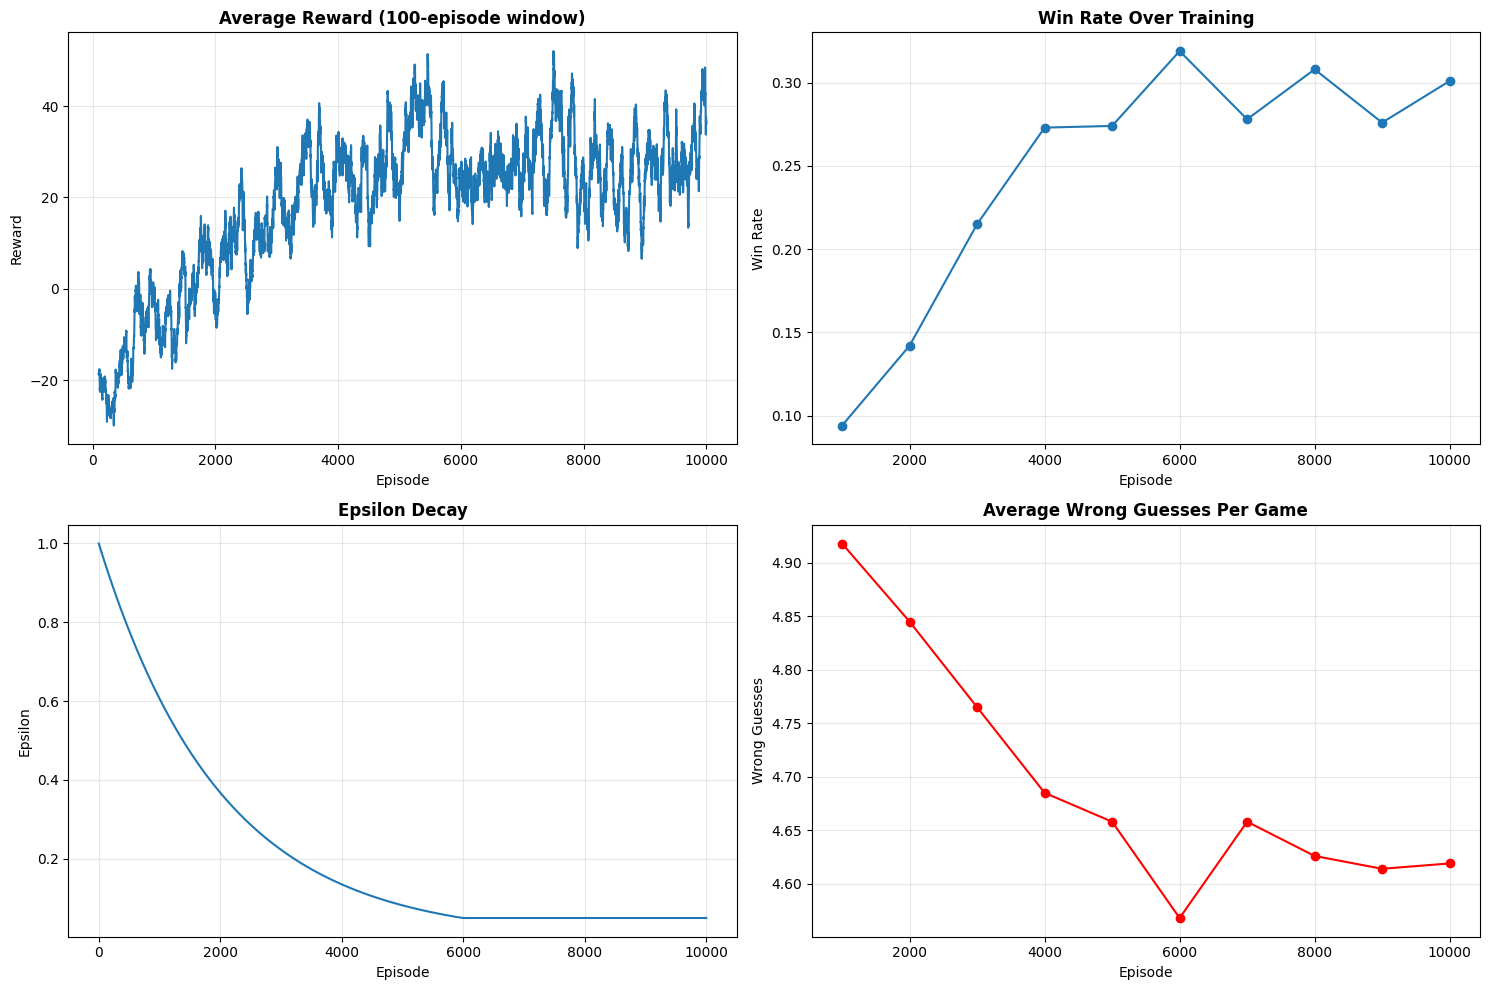

Training plots saved as 'training_progress.png'


In [141]:
# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rewards
window = 100
rolling_rewards = pd.Series(episode_rewards).rolling(window).mean()
axes[0, 0].plot(rolling_rewards)
axes[0, 0].set_title('Average Reward (100-episode window)', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(alpha=0.3)

# Win rate
eval_episodes = np.arange(eval_frequency, n_episodes + 1, eval_frequency)
axes[0, 1].plot(eval_episodes, win_rates, marker='o')
axes[0, 1].set_title('Win Rate Over Training', fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].grid(alpha=0.3)

# Epsilon decay
axes[1, 0].plot(epsilon_history)
axes[1, 0].set_title('Epsilon Decay', fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].grid(alpha=0.3)

# Average wrong guesses
axes[1, 1].plot(eval_episodes, avg_wrong_guesses, marker='o', color='red')
axes[1, 1].set_title('Average Wrong Guesses Per Game', fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Wrong Guesses')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training plots saved as 'training_progress.png'")

# Testing

In [145]:
def evaluate_agent(agent, test_words, max_games=None, verbose=True):
    """
    Evaluate agent on test set.
    """
    if max_games:
        test_words = test_words[:max_games]

    results = {
        'wins': 0,
        'losses': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'game_details': []
    }

    for word in tqdm(test_words, desc="Evaluating"):
        game = HangmanGame(word)
        state = game.reset()

        wrong_guesses = 0
        repeated_guesses = 0

        while not game.game_over:
            action = agent.choose_action(state, game, training=False)

            if action is None:
                break

            next_state, reward, done, info = game.step(action)

            if 'repeated' in info:
                repeated_guesses += 1
            elif 'wrong' in info:
                wrong_guesses += 1

            state = next_state

        # Record results
        if game.won:
            results['wins'] += 1
        else:
            results['losses'] += 1

        results['total_wrong_guesses'] += wrong_guesses
        results['total_repeated_guesses'] += repeated_guesses

        results['game_details'].append({
            'word': word,
            'won': game.won,
            'wrong_guesses': wrong_guesses,
            'repeated_guesses': repeated_guesses
        })

    # Calculate final score
    total_games = len(test_words)
    success_rate = results['wins'] / total_games

    final_score = (
        (success_rate * 200000) -
        (results['total_wrong_guesses'] * 5) -
        (results['total_repeated_guesses'] * 2)
    )

    results['total_games'] = total_games
    results['success_rate'] = success_rate
    results['final_score'] = final_score
    results['avg_wrong_guesses'] = results['total_wrong_guesses'] / total_games
    results['avg_repeated_guesses'] = results['total_repeated_guesses'] / total_games

    if verbose:
        print("\n" + "=" * 60)
        print("EVALUATION RESULTS")
        print("=" * 60)
        print(f"Total Games: {total_games}")
        print(f"Wins: {results['wins']}")
        print(f"Losses: {results['losses']}")
        print(f"Success Rate: {success_rate:.2%}")
        print(f"Total Wrong Guesses: {results['total_wrong_guesses']}")
        print(f"Total Repeated Guesses: {results['total_repeated_guesses']}")
        print(f"Avg Wrong Guesses/Game: {results['avg_wrong_guesses']:.2f}")
        print(f"Avg Repeated Guesses/Game: {results['avg_repeated_guesses']:.2f}")
        print("\n" + "=" * 60)
        print(f"FINAL SCORE: {final_score:.2f}")
        print("=" * 60)

    return results

print("Evaluation function ready!")

Evaluation function ready!


In [146]:
# Evaluate on full test set
print(f"Evaluating on {len(test_words)} test words...\n")
test_results = evaluate_agent(agent, test_words)

Evaluating on 2000 test words...



Evaluating: 100%|██████████| 2000/2000 [01:30<00:00, 22.09it/s]


EVALUATION RESULTS
Total Games: 2000
Wins: 636
Losses: 1364
Success Rate: 31.80%
Total Wrong Guesses: 9129
Total Repeated Guesses: 0
Avg Wrong Guesses/Game: 4.56
Avg Repeated Guesses/Game: 0.00

FINAL SCORE: 17955.00



Performance by Word Length:
             Total Games  Wins  Win Rate  Avg Wrong  Avg Repeated
word_length                                                      
2                      2     0     0.000      5.000           0.0
3                      9     0     0.000      5.000           0.0
4                     37     2     0.054      4.919           0.0
5                     91     8     0.088      4.901           0.0
6                    138    20     0.145      4.833           0.0
7                    205    35     0.171      4.829           0.0
8                    246    54     0.220      4.776           0.0
9                    274    52     0.190      4.799           0.0
10                   282    66     0.234      4.688           0.0
11                   226    68     0.301      4.717           0.0
12                   164    58     0.354      4.585           0.0
13                   128    48     0.375      4.500           0.0
14                    86    34     0.395      4

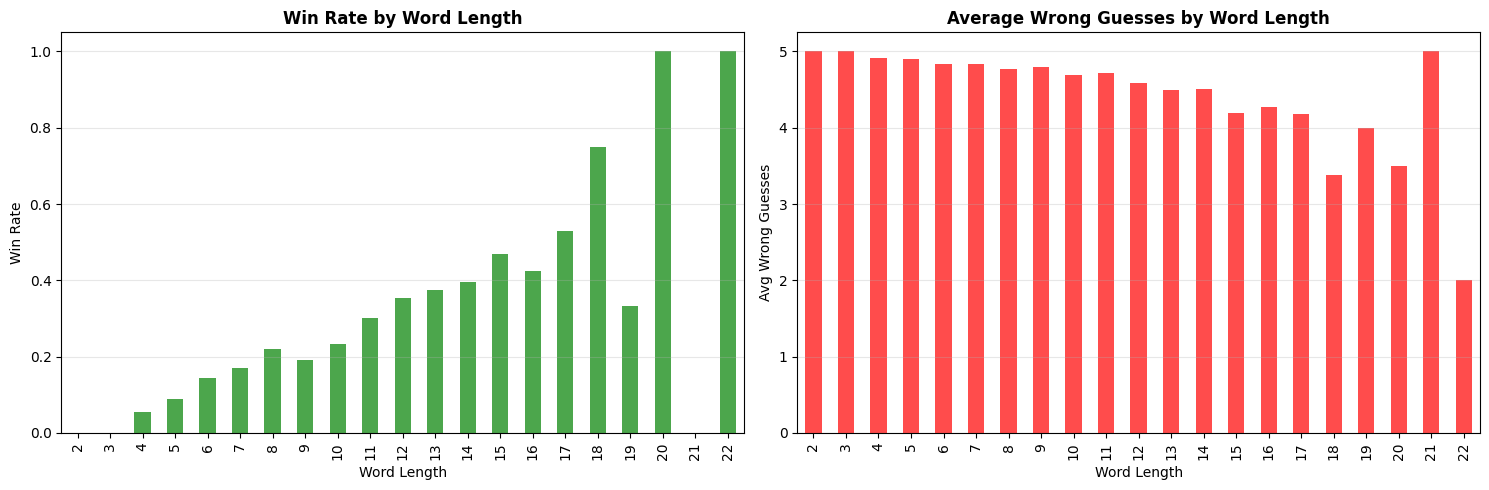

In [70]:
# Analyze performance by word length
results_df = pd.DataFrame(test_results['game_details'])
results_df['word_length'] = results_df['word'].apply(len)

# Group by length
length_analysis = results_df.groupby('word_length').agg({
    'won': ['count', 'sum', 'mean'],
    'wrong_guesses': 'mean',
    'repeated_guesses': 'mean'
}).round(3)

length_analysis.columns = ['Total Games', 'Wins', 'Win Rate',
                           'Avg Wrong', 'Avg Repeated']

print("\nPerformance by Word Length:")
print(length_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Win rate by length
length_analysis['Win Rate'].plot(kind='bar', ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Win Rate by Word Length', fontweight='bold')
axes[0].set_xlabel('Word Length')
axes[0].set_ylabel('Win Rate')
axes[0].grid(alpha=0.3, axis='y')

# Average wrong guesses by length
length_analysis['Avg Wrong'].plot(kind='bar', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Average Wrong Guesses by Word Length', fontweight='bold')
axes[1].set_xlabel('Word Length')
axes[1].set_ylabel('Avg Wrong Guesses')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('word_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [71]:
# Find words the agent struggled with
lost_words = results_df[results_df['won'] == False].sort_values(
    'wrong_guesses', ascending=False
)

print("\nTop 20 Most Difficult Words (Lost Games):")
print(lost_words[['word', 'word_length', 'wrong_guesses', 'repeated_guesses']].head(20))

# Words with repeated guesses
repeated = results_df[results_df['repeated_guesses'] > 0].sort_values(
    'repeated_guesses', ascending=False
)

print("\nTop 10 Words with Most Repeated Guesses:")
print(repeated[['word', 'won', 'wrong_guesses', 'repeated_guesses']].head(10))


Top 20 Most Difficult Words (Lost Games):
                word  word_length  wrong_guesses  repeated_guesses
1999          wrasse            6              5                 0
0            fangled            7              5                 0
1       cerebropedal           12              5                 0
2         moxieberry           10              5                 0
3            sponged            7              5                 0
4      cloudlessness           13              5                 0
5           abhorson            8              5                 0
6         unsufficed           10              5                 0
7               cagn            4              5                 0
9         uncasketed           10              5                 0
10           tenuity            7              5                 0
12              wusp            4              5                 0
1974          carboy            6              5                 0
1973         hornil

In [89]:
print("\n" + "="*70)
print("DIAGNOSTIC ANALYSIS")
print("="*70)

# Test HMM quality on ACTUAL corpus words
import random
random.seed(42)

correct_first_guess = 0
correct_in_top3 = 0
total_tests = 100

test_sample = random.sample(corpus_words, min(100, len(corpus_words)))

for test_word in test_sample:
    # Simulate mid-game: reveal 2 letters
    if len(test_word) < 3:
        continue

    reveal_positions = random.sample(range(len(test_word)), min(2, len(test_word)))
    masked = ''.join([test_word[i] if i in reveal_positions else '_'
                      for i in range(len(test_word))])
    guessed = set(test_word[i] for i in reveal_positions)

    # Get HMM prediction
    probs = hmm.get_letter_probabilities(masked, guessed)
    if not probs:
        continue

    top_predictions = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]

    # What we actually need
    remaining_letters = set(test_word) - guessed

    if top_predictions and top_predictions[0][0] in remaining_letters:
        correct_first_guess += 1

    if any(pred[0] in remaining_letters for pred in top_predictions):
        correct_in_top3 += 1

print(f"\nHMM Prediction Accuracy (on {total_tests} corpus words):")
print(f"  First guess correct: {correct_first_guess/total_tests:.1%}")
print(f"  Correct in top 3: {correct_in_top3/total_tests:.1%}")

print(f"\n{'='*70}")

# Analyze by game stage
print("\nPerformance by Game Stage:")

for stage, reveal_ratio in [("Early (1 letter)", 0.15),
                             ("Mid (40% letters)", 0.40),
                             ("Late (70% letters)", 0.70)]:
    correct = 0
    total = 0

    for test_word in test_sample[:50]:
        if len(test_word) < 3:
            continue

        reveal_count = max(1, int(len(test_word) * reveal_ratio))
        reveal_positions = random.sample(range(len(test_word)), reveal_count)
        masked = ''.join([test_word[i] if i in reveal_positions else '_'
                          for i in range(len(test_word))])
        guessed = set(test_word[i] for i in reveal_positions)

        probs = hmm.get_letter_probabilities(masked, guessed)
        if not probs:
            continue

        top_pred = max(probs, key=probs.get)
        remaining = set(test_word) - guessed

        if top_pred in remaining:
            correct += 1
        total += 1

    if total > 0:
        print(f"  {stage}: {correct/total:.1%}")

print(f"\n{'='*70}")

# Check if specific patterns work
print("\nPattern Recognition Tests:")

patterns = [
    ("q_", "qu", "u"),
    ("_q", "aq", "a"),
    ("th_", "the", "e"),
    ("__e", "the", "th"),
    ("___ing", "testing", "test"),
]

for masked, actual, expected_letters in patterns:
    guessed = set(c for c in masked if c != '_')
    probs = hmm.get_letter_probabilities(masked, guessed)

    if probs:
        top_3 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
        top_letters = [l for l, p in top_3]

        found = any(e in top_letters for e in expected_letters)
        status = "✓" if found else "✗"

        print(f"  {status} {masked:10s} → Top 3: {top_letters} (want: {list(expected_letters)})")

print("="*70)


DIAGNOSTIC ANALYSIS

HMM Prediction Accuracy (on 100 corpus words):
  First guess correct: 58.0%
  Correct in top 3: 94.0%


Performance by Game Stage:
  Early (1 letter): 58.0%
  Mid (40% letters): 48.0%
  Late (70% letters): 30.0%


Pattern Recognition Tests:
  ✓ q_         → Top 3: ['u', 'e', 'y'] (want: ['u'])
  ✓ _q         → Top 3: ['s', 'p', 'a'] (want: ['a'])
  ✓ th_        → Top 3: ['e', 'o', 'a'] (want: ['e'])
  ✓ __e        → Top 3: ['t', 'r', 'n'] (want: ['t', 'h'])
  ✓ ___ing     → Top 3: ['t', 'r', 'a'] (want: ['t', 'e', 's', 't'])
